# In this notebook we analyze the simulations produced in the corresponding C++ files. We show that the relations between the microscope resolution $d$ and the parameters: FWHM (full width at half maximum of the point spread function), $t$ (illumination) and $n$ (discretization) hold as predicted by the asymptotic theory ($t, n\to\infty$, $d\to0$). Already for low parameter values of $t$ and $n$ the asymptotic theory approximates well the actual simulations

## Main code

In [2]:
import os
import numpy   as np
import pandas  as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pylab

import math as mt
from scipy.stats import norm

from pathlib import Path

cwd  = os.getcwd()

log  = np.log
exp  = np.exp
sqrt = np.sqrt
pi   = mt.pi
erf  = mt.erf


# colors
blue = '#4682B4'
red  = '#B4464B'
beige = '#B4AF46'
brown = '#B47846'

models = ['binomial_', 'poisson_', 'gaussEquivPoi_', 'gauss_']
models_short = ['poisson_', 'gaussEquivPoi_', 'gauss_']
modelsGauss = ['gaussEquivPoi_', 'gauss_']


def findBoundary(data, howClose = 0.1):
    "Picks out rows corresponding to values"
    "when detection boundary is just reached."
    
    level = data['level'].iloc[0]
    
    df = data.loc[(data['error2'] < (1+howClose/2)*level) & (data['error2'] >= (1-howClose/2)*level)]
    
    return df        


def getModel(fileName):
    for mod in models:
        if (fileName.find(mod) != -1):
            model = mod[:-1]
    return model


def fitLine(fileName, var, logged = True, plotName = "default",\
    withLegend = False, withFormula = True, savePlot = False,\
    autoScales = True, xLabels = [], minorTicksX = [],\
            yLabels = [], minorTicksY = [], yDecimals = 2, loggedFormula = False, dims = 1):
    "Fits a line to the corresponding data."
                    
    df = pd.read_csv(fileName)
    
    model = getModel(fileName)
    
    df = findBoundary(df)
    
    df['| level - error2 |'] = abs( df['level'] - df['error2'] )
    
    # remove repeated values
    df = df.sort_values('| level - error2 |', ascending=True).drop_duplicates(var).sort_index()
    
    if (logged):
        x = log(df[var])
        y = log(df['d'])
    else:
        x = df[var]
        y = df['d']
    
    coeffs = np.polyfit(x, y, deg=1)
    poly = np.poly1d(coeffs)

    yFit = lambda x: poly(x)

    fig, ax = plt.subplots()
    plt.plot(x, yFit(x), label='fit')
    plt.plot(x, y, 'bo', label='data')
    
    t = df['t'].iloc[0]
    try:
        n = df['n'].iloc[0]
    except KeyError:
        n = df['gridSize2D'].iloc[0]
    
    fwhm  = df['fwhm'].iloc[0]
    
#     try:
#          fwhm  = df['fwhm'].iloc[0]
#     except KeyError:
#          fwhm  = df['fwhm1'].iloc[0]
    
    level = df['level'].iloc[0]
    
    printPars(df, var, t, n, fwhm)
    print()
    
    qLoc = fileName.find("_q=")
    if (fileName.find("_q=") != -1):
        q = int(fileName[qLoc + 3: qLoc +6 ])/1000.0
    else:
        q = 0.5
    
    print("q = ", q)
    yTh = lambda x: resolutionFormula (model, var, t, n, fwhm, level, 1-level, coeffs, 
                                       q, logged, dims)(x)
    
    printResolutionFormula(model, var, t, n, fwhm, level, 1-level, coeffs, q, loggedFormula, dims)
    
    plt.plot(x, yTh(x), label='theory')
    
    if (withLegend):
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    if (withFormula):
        if (logged):            
            plt.title(r'$d = $' + r'${:.3g}$'.format(exp(coeffs[1])) + \
                      r'$\/{}$'.format(var) + r'$^{{{:.3g}}}$'.format(coeffs[0]),\
                     fontsize=18)  
            
            if autoScales:
                howMany = 6

                xLabels = np.linspace(min(df[var]), max(df[var]), num=howMany)
                minorTicksX = np.linspace(min(df[var]), max(df[var]), num=2*howMany-1)

                if (var == 'fwhm'):
                    xLabels = np.around( xLabels, decimals=2 )
                    minorTicksX = np.around( minorTicksX, decimals=2 )
                else:
                    xLabels = np.around(xLabels).astype(int)
                    minorTicksX = np.around(minorTicksX).astype(int)

                ax.set_xticks(log(xLabels))
                ax.set_xticks(log(minorTicksX), minor=True)
                ax.set_xticklabels(xLabels)
                
                yMin = min(exp(min(yTh(x))),  min(df['d']))
                yMax = max(exp(max(yTh(x))),  max(df['d']))
                
                yLabels = np.around( np.linspace(yMin, yMax, num=7), decimals=2 )

                ax.set_yticks(log(yLabels))
                ax.set_yticklabels(yLabels)
            else:
                ax.set_xticks(log(xLabels))
                ax.set_xticks(log(minorTicksX), minor=True)
                ax.set_xticklabels(xLabels)
                
                ax.set_yticks(log(yLabels))
                ax.set_yticks(log(minorTicksY), minor=True)
                
                myString = "{:10." + str(yDecimals) + "f}"
                yLabels = [myString.format(label) for label in yLabels]
                ax.set_yticklabels(yLabels)
    
        else:
            plt.title(r'$d = $' + r'${:.3g}$'.format(coeffs[0]) + \
            r'$\/{}$'.format(var) + "+" + r'${{{:.3g}}}$'.format(coeffs[1]),\
                     fontsize=18)
            
    ax.grid(which='both')

                     
    plt.xlabel(r'${}$'.format(var), fontsize=16)   
    plt.ylabel(r'$d$', fontsize=16, labelpad=-20) # only for seprately exported plots!!!
    plt.tick_params(axis='both', which='major', labelsize=14)
            
    plt.tight_layout()
    plt.grid(True)
    if(savePlot):
        Path(cwd + "/plots/").mkdir(parents=True, exist_ok=True)
        print(cwd + "/plots/" + plotName + ".pdf")
        plt.savefig(cwd + "/plots/" + plotName + ".pdf") 
    plt.show()
    print()
    print()
    print("---------------------------------------------------------------------")

    
    
def printPars(df, var, t, n, fwhm):
    varmin = min(df[var])
    varmax = min(df[var])
    
    if (var == 't'):
        print("t = ", varmin, ",...,", varmax)
        print("n = ", n)
        print("fwhm = ", fwhm)
    elif (var == 'n'):
        print("n = ", varmin, ",...,", varmax)
        print("t = ", t)
        print("fwhm = ", fwhm)
    elif (var == 'fwhm'):
        print("fwhm = ", varmin, ",...,", varmax)
        print("n = ", n)
        print("t = ", t)

        

def fitMultipleLines(filePath, logged = True, savePlot = False):
    variables = ['_fwhm_', '_t_', '_n_']
    
    for fileName in os.listdir(filePath):
        for variable in variables:
            if (fileName.find(variable) != -1):
                var = variable[1:-1]
        print(fileName[:-4])
        fitLine(filePath + fileName, var, logged, plotName = fileName[:-4], savePlot = True)
      
        

def compareLineFitToTheory (fileName, varFit, par):
    df = pd.read_csv(fileName)
    parValue = df[par][0]
    resolutionTheory = resolutionFormula (parValue, par)
    print ('theory for ' + par + ' = ' + str(parValue) )
    print( format( resolutionTheory, '.4f') + ' x')
    dfBoundary = findBoundary(df, howClose = 0.11)
    fitLine(fileName, varFit, False, "", howClose = 0.11, withLegend = True, savePlot = False)

    

def resolutionFormula (model, whichOne, t, n, fwhm, level, power, coeffs, q = 0.5, logged = True,
                       dims = 1, whichFwhm = 'first'):
    "Returns the THEORETICAL asymptotic resolution formula corresponding to the current model."
    
    qSqrt = sqrt(norm.ppf(power, loc=0, scale=1)-norm.ppf(level, loc=0, scale=1))
    asymPar = sqrt(2)/( sqrt( q*(1-q) ) ) # parameter for asymmetric problem
                
    if (model == "gauss"):
        
        if whichFwhm == 'first':
            fwhmExp = 1.25
        elif whichFwhm == 'second' or whichFwhm == 'third':
            fwhmExp = 0.25
        else:
            fwhmExp = 1 + 0.25*dims
            
        nExp = dims / 4
        
        if dims == 1: 
            coeff = asymPar*qSqrt *pi**(1/8) / (2**(9/8) *3**(1/4)*log(2)**(5/8))
        elif dims == 2:
            # hardcode other fwhms to 0.2
            if whichFwhm == 'first':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))*0.2**0.25
            elif whichFwhm == 'second':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))*0.2**1.25
            elif whichFwhm == 'both':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))
        elif dims == 3:
            if whichFwhm == 'first':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))*0.2**0.5
            elif whichFwhm == 'second' or whichFwhm == 'third':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))*0.2**1.5
            elif whichFwhm == 'all':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))
                
        if (not logged):
            if (whichOne == "t"):
                y = lambda x: coeff * n**nExp * x**(-1/2) * fwhm**fwhmExp
            elif (whichOne == "fwhm"):
                y = lambda x: coeff * n**nExp * t**(-1/2) * x**fwhmExp
            elif (whichOne == "n"):
                y = lambda x: coeff * x**nExp * t**(-1/2) * fwhm**fwhmExp
        else:
            if (whichOne == "t"):
                offset = log(coeff * n**nExp * fwhm**fwhmExp)
                y = lambda x: -1/2*x + offset
                
            elif (whichOne == "fwhm"):
                offset = log(coeff * n**nExp  * t**(-1/2))
                y = lambda x:  fwhmExp*x + offset
                
            elif (whichOne == "n"):
                offset = log(coeff * t**(-1/2) * fwhm**fwhmExp)
                y = lambda x:  nExp*x + offset
   
    else: 
        # same expression in all dimensions
        coeff = asymPar*qSqrt* ( 2**(7/4)*sqrt(log(2)) )**(-1)
        
        if dims != 1:
            if whichFwhm == 'second' or whichFwhm == 'third':
                coeff *= 0.2 # hardcode to 0.2
                                
        if (not logged):
            if   (whichOne == "t"):
                y = lambda x: coeff * x**(-1/4) * fwhm
            elif (whichOne == "fwhm"):
                if (whichFwhm == 'second' or whichFwhm == 'third') and dims != 1:
                    y = lambda x: 0*x + coeff *t**(-1/4)
                else:
                    y = lambda x: coeff * t**(-1/4) * x
            elif (whichOne == "n"):
                y = lambda x: 0*x+coeff * t**(-1/4) * fwhm
        else:
            if   (whichOne == "t"):
                offset = log(coeff * fwhm)
                y = lambda x: -1/4*x + offset
                
            elif (whichOne == "fwhm"):
                if (whichFwhm == 'second' or whichFwhm == 'third') and dims != 1:
                    offset = log(coeff * t**(-1/4))
                    y = lambda x: 0*x + offset
                else:
                    offset = log(coeff * t**(-1/4))
                    y = lambda x: x + offset
            elif (whichOne == "n"):
                y = lambda x: 0*x + log(coeff * t**(-1/4) * fwhm)
    return y


def printResolutionFormula(model, whichOne, t, n, fwhm, level, power, coeffs, q = 0.5, logged = True,
                            dims = 1, whichFwhm = 'first'):
    "Prints the resolution formula."
    
    qSqrt = sqrt(norm.ppf(power, loc=0, scale=1)-norm.ppf(level, loc=0, scale=1))
    asymPar = sqrt(2)/( sqrt( q*(1-q) ) ) # parameter for asymmetric problem
                
    if (model == "gauss"):
        
        if whichFwhm == 'first':
            fwhmExp = 1.25
        elif whichFwhm == 'second' or whichFwhm == 'third':
            fwhmExp = 0.25
        elif whichFwhm == 'both' or whichFwhm == 'all':
            fwhmExp = 1 + 0.25*dims
            
        nExp = dims / 4
        
        if dims == 1: 
            coeff = asymPar*qSqrt *pi**(1/8) / (2**(9/8) *3**(1/4)*log(2)**(5/8))
        elif dims == 2:
            # hardcode other fwhms to 0.2
            if whichFwhm == 'first':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))*0.2**0.25
            elif whichFwhm == 'second':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))*0.2**1.25
            elif whichFwhm == 'both':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))
        elif dims == 3:
            if whichFwhm == 'first':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))*0.2**0.5
            elif whichFwhm == 'second' or whichFwhm == 'third':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))*0.2**1.5
            elif whichFwhm == 'all':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))
        
        print('coeff: ', coeff)
        
        if (whichOne == "t"):
            offset = log(coeff * n**nExp * fwhm**fwhmExp)

            if logged == True:
                print("Fit: \hspace{6mm}$\log(d) = " + r'{:+.3g}'.format(coeffs[0]) + "\log(t)" 
                                                     + r'{:+.3g}'.format(coeffs[1]) + "$\\\\")
                print("Theory: $\log(d) = -0.500 \log(t)" + r'{:+.3g}'.format(offset) + "$")

            elif logged == False:
                print("Fit:    $ d = " + r'{:.3g}'.format(exp(coeffs[1])) + "\,t^{"
                                       + r'{:.3g}'.format(coeffs[0])      + "}$\\\\" )
                print("Theory: $ d = " + r'{:.3g}'.format(exp(offset))    + "\, t^{-0.5}$")
                
        elif whichOne == "fwhm":
            offset = log(coeff * n**nExp  * t**(-1/2))
            y = lambda x: coeff * n**nExp * t**(-1/2) * x**fwhmExp
                
            if logged == True:
                print("Fit: \hspace{6mm}$\log(d) = " + r'{:.3g}'.format(coeffs[0]) + "\log(\\fwhm)" 
                                                     + r'{:.3g}'.format(coeffs[1]) + "$\\\\")
                print("Theory: $\log(d) = "+ r'{:.3g}'.format(fwhmExp) + "\log(\\fwhm)" 
                                           + r'{:.3g}'.format(offset)  + "$")

            elif logged == False:
                print("Fit: $d = " + r'{:.3g}'.format(exp(coeffs[1])) + "\\fwhm^{" 
                                   + r'{:.3g}'.format(coeffs[0])      + "}$\\\\")
                print("Theory: $d = " + r'{:.3g}'.format(exp(offset)) + "\\fwhm^{"
                                      + r'{:.3g}'.format(fwhmExp)    + "}$")
                
                print("Ratio: ", exp(offset)/exp(coeffs[1]))
                
        elif whichOne == "n":
            offset = log(coeff * t**(-1/2) * fwhm**fwhmExp)

            if logged == True:
                print("Fit: \hspace{6mm}$\log(d) = " + r'{:+.3g}'.format(coeffs[0]) + "\log(n)" 
                                                     + r'{:+.3g}'.format(coeffs[1]) + "$\\\\")
                print("Theory: $\log(d) =" + r'{:+.3g}'.format(nExp)   + "\log(n)" 
                                           + r'{:+.3g}'.format(offset) + "$")

            elif logged == False:
                print("Fit: $d = " + r'{:.3g}'.format(exp(coeffs[1])) + "\,n^{" + r'{:.3g}'.format(coeffs[0]) 
                                   + "}$\\\\")
                print("Theory: $d = " + r'{:.3g}'.format(exp(offset)) + "\,n^{"  
                                      + r'{:.3g}'.format(nExp) + "}$")
                
    else:
       # same expression in all dimensions
        coeff = asymPar*qSqrt* ( 2**(7/4)*sqrt(log(2)) )**(-1)
        
        if dims != 1:
            if whichFwhm == 'second' or whichFwhm == 'third':
                coeff *= 0.2 # hardcode to 0.2
                        
        if whichOne == "t":
            offset = log(coeff * fwhm)
            y = lambda x: -1/4*x + offset

            if logged == True:
                print("Fit: \hspace{6mm}$\log(d) = " + r'{:+.3g}'.format(coeffs[0]) + "\log(t)" 
                                                     + r'{:+.3g}'.format(coeffs[1]) + "$\\\\")
                print("Theory: $\log(d) = -0.250 \log(t)" + r'{:+.3g}'.format(offset) + "$")

            elif logged == False:
                print("Fit:    $ d = " + r'{:.3g}'.format(exp(coeffs[1])) + "\,t^{"
                                       + r'{:.3g}'.format(coeffs[0])      + "}$\\\\" )
                print("Theory: $ d = " + r'{:.3g}'.format(exp(offset)) + "\, t^{-0.250}" + "$")

        elif whichOne == "fwhm":
            
            offset = log(coeff * t**(-1/4))
            y = lambda x: x + offset

            if logged == True:
                if (whichFwhm == 'second' or whichFwhm == 'third') and dims != 1:
                    print("Fit: \hspace{6mm}$\log(d) = " + r'{:.3g}'.format(coeffs[0]) + "\log(\\fwhm)" 
                                                         + r'{:.3g}'.format(coeffs[1]) + "$\\\\")
                    print("Theory: $\log(d) = " + r'{:+.3g}'.format(offset) + "$\\\\")
                else:
                    print("Fit: \hspace{6mm}$\log(d) = " + r'{:.3g}'.format(coeffs[0]) + "\log(\\fwhm)" 
                                                         + r'{:.3g}'.format(coeffs[1]) + "$\\\\")
                    print("Theory: $\log(d) = 1.000\log(\\fwhm)" + r'{:+.3g}'.format(offset) + "$\\\\")

            elif logged == False:
                if (whichFwhm == 'second' or whichFwhm == 'third') and dims != 1:
                    print("Fit: $d = " + r'{:.3g}'.format(exp(coeffs[1])) 
                                       + "\\fwhm^{" + r'{:.3g}'.format(coeffs[0]) + "}$\\\\")
                    print("Theory: $d = " + r'{:.3g}'.format(exp(offset))         + "$\\\\")

                    print("Ratio: ", exp(offset)/exp(coeffs[1]))
                else:
                    print("Fit: $d = " + r'{:.3g}'.format(exp(coeffs[1])) 
                                       + "\\fwhm^{" + r'{:.3g}'.format(coeffs[0]) + "}$\\\\")
                    print("Theory: $d = " + r'{:.3g}'.format(exp(offset))         + "\\fwhm$")

                    print("Ratio: ", exp(offset)/exp(coeffs[1]))

        elif whichOne == "n":
            y = lambda x: 0*x + log(coeff * t**(-1/4) * fwhm)

            if logged == True:
                print("Theory: ", r'{:+.3g}'.format(log(coeff * t**(-1/4) * fwhm)))
                print("Fit: $d = " + r'{:.3g}'.format(exp(coeffs[1])) 
                                   + "\,n^{" + r'{:.3g}'.format(coeffs[0]) + "}$\\\\")
            elif logged == False:
                print("Fit: $d = " + r'{:.3g}'.format(exp(coeffs[1])) 
                                   + "\,n^{" + r'{:.3g}'.format(coeffs[0]) + "}$\\\\")
                print("Theory: $d = " + r'{:.3g}'.format(coeff * t**(-1/4) * fwhm) + "$")
                

    
def fitLineOnDataFrame(df, variable, logged = False):
    if (logged):
        logx = np.log(df[variable])
        logy = np.log(df['d'])
        coeffs = np.polyfit(logx, logy, deg=1)
        poly = np.poly1d(coeffs)

        yFit = lambda x: np.exp(poly(np.log(x)))
    else:
        x = df[variable]
        y = df['d']
        coeffs = np.polyfit(x, y, deg=1)
        poly = np.poly1d(coeffs)

        yFit = lambda x: poly(x)
    
    print(coeffs)
    
    plt.plot(df[variable], yFit(df[variable]))
    plt.plot(df[variable], df['d'], 'bo')
    
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
    
    
def percentError(df, theoreticalData):
    "Writes out percentage error between theory and simulations."
    
    df['d theory'] = theoreticalData
    df['absolute error'] = abs(df['d']-df['d theory'])
    df['percent error']  = 100*abs(df['d']-df['d theory']) / df['d theory']
    
    return df

def export_legend(legend, filename="legend.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)



def saveAllPlotsTogether(fileEnding, filePath, var, xLabels = [], minorTicksX = [],
            yLabels = [], minorTicksY = [], yDecimals = 2, 
            q = 0.5, logged = True, loggedFormula = True, dims = 1, whichFwhm = 'first',            
            legend = True, includeBinomial = True):
    "The main function of the notebook. Combines all the functions above to"
    "fit lines on the corresponding data and export the result as a pdf."
    
    dfs = []
    
    # For the 1D paper plots have not used the binomial model.
    if includeBinomial:
        mods = models
    else:
        mods = models_short
    
    for model in mods:
        fileName = model + var + '_' + fileEnding

        df = pd.read_csv(filePath + fileName)
        df = findBoundary(df)
        df['| level - error2 |'] = abs( df['level'] - df['error2'] )
        
        # remove repeated values
        df = df.sort_values('| level - error2 |', ascending=True).drop_duplicates(var).sort_index()
        dfs.append(df)
    
    t = df['t'].iloc[0]
    n = df['n'].iloc[0]
    
    fwhm = df['fwhm'].iloc[0]
    level = df['level'].iloc[0]
    
    if var == 'fwhm':
        if dims > 1:
            plotName = 'd_vs_'+ var + '_' + whichFwhm + '_t=' + str(t) + '_n=' + str(n) + '_dims=' + str(dims)\
                       +  '_q=' + str(1000*q)[:-2]
        else:
            plotName = 'd_vs_'+ var + '_t=' + str(t) + '_n=' + str(n) + '_dims=' + str(dims)\
                        +  '_q=' + str(1000*q)[:-2]
    elif var == 't':
        plotName = 'd_vs_'+ var + '_fwhm=' + str(100*fwhm)[:-2] + '_n=' + str(n) + '_dims=' + str(dims)\
                   + '_q=' + str(1000*q)[:-2]
    else:
        plotName = 'd_vs_'+ var + '_t=' + str(t) + '_fwhm=' + str(100*fwhm)[:-2] + '_dims=' + str(dims)\
                   + '_q=' + str(1000*q)[:-2]
            
    if includeBinomial:
        plotLabels = ['bin', 'poi', 'VSG', 'gauss']

        dotStyles = ['o', '^', 's', 'D']
#     'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'
        colors = [blue, 'orange', 'green', red]
    else:
        plotName += '_withoutBinomial'
        
        plotLabels = ['poi', 'VSG', 'gauss']

        dotStyles = ['^', 's', 'D']
#     'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'
        colors = ['orange', 'green', red]

    
    fig, ax = plt.subplots()

    
    for i in range(len(mods)):
        x = log(dfs[i][var])
        y = log(dfs[i]['d'])

        coeffs = np.polyfit(x, y, deg=1)
        poly = np.poly1d(coeffs)

        yFit = lambda x: poly(x)

        print(plotLabels[i])
        
        filledIndex = 1 if includeBinomial else 0
        
        if i == filledIndex:
            plt.plot(x, y, dotStyles[i], label=plotLabels[i], color = colors[i])
        else:
            plt.plot(x, y, dotStyles[i], label=plotLabels[i], markerfacecolor='none', color = colors[i])
        
        model = mods[i][:-1]
        
        printResolutionFormula (model, var, t, n, fwhm, level, 1-level, coeffs, q, loggedFormula, dims, whichFwhm)
        print()

    
    ax.set_xticks(log(xLabels))
    ax.set_xticks(log(minorTicksX), minor=True)
    ax.set_xticklabels(xLabels)
    
    ax.set_yticks(log(yLabels))
    ax.set_yticks(log(minorTicksY), minor=True)
    
    x = log(xLabels)
    
    yTh = lambda x: resolutionFormula ('poisson', var, t, n, fwhm, level, 1-level, coeffs,
                                            q, logged, dims, whichFwhm)(x)
    if includeBinomial:
        plt.plot(x, yTh(x),  color = blue, label = 'theory bin, poi, VSG')
    else:
        plt.plot(x, yTh(x),  color = blue, label = 'theory poi, VSG')
    
    yTh = lambda x: resolutionFormula ('gauss', var, t, n, fwhm, level, 1-level, coeffs,
                                       q, logged, dims, whichFwhm)(x)
    plt.plot(x, yTh(x), color = red, label = 'theory gauss', linestyle = '--')
    
    
    
    myString = "{:10." + str(yDecimals) + "f}"
    yLabels = [myString.format(label) for label in yLabels]
    ax.set_yticklabels(yLabels)
    ax.grid(which='both')
    
    plt.xlabel(r'${}$'.format(var), fontsize=16)
    if var == 'fwhm':
        if dims > 1:
            if whichFwhm == 'first':
                plt.xlabel('$fwhm_{1}$', fontsize=16)
            elif whichFwhm == 'second':
                plt.xlabel('$fwhm_{2}$', fontsize=16)
            elif whichFwhm == 'third':
                plt.xlabel('$fwhm_{3}$', fontsize=16)
            elif whichFwhm == 'both':
                plt.xlabel('$fwhm_{1} = fwhm_{2}$', fontsize=16)
            elif whichFwhm == 'all':
                plt.xlabel('$fwhm_{1} = fwhm_{2} = fwhm_{3}$', fontsize=16)
        
        
    plt.ylabel(r'$d$', fontsize=16, labelpad=5) # only for seprately exported plots!!!
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.grid(True)
    
    print(plotName)
    
    if legend:
        if includeBinomial:
            legendName = "simulationLegend"
            lgd = ax.legend(loc=9, bbox_to_anchor=(0.5,0))
            legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)
        else:
            legendName = "simulationLegend_withoutBinomial"
            lgd = ax.legend(loc=9, bbox_to_anchor=(0.5,0))
            legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=3)
        export_legend(legend, cwd + "/plots/" + legendName + ".pdf")    
    
    if var == 'fwhm':
        plt.title('$t=' + str(t) + ',\, n=' + str(n) + '$', fontsize=18)
        if dims != 1:
            if whichFwhm == 'first':
                plt.title('$t=' + str(t) + ',\, n=' + str(n) + ', fwhm_{2} = 0.2$', fontsize=18)
            elif whichFwhm == 'second':
                plt.title('$t=' + str(t) + ',\, n=' + str(n) + ', fwhm_{1} = 0.2$', fontsize=18)
                
                if dims == 3:
                    plt.title('$t=' + str(t) + ',\, n=' + str(n) + ', fwhm_{1} = fwhm_{2}= 0.2$', fontsize=18)
            elif whichFwhm == 'third':
                plt.title('$t=' + str(t) + ',\, n=' + str(n) + ', fwhm_{1} = fwhm_{2} = 0.2$', fontsize=18)
    elif var == 't':
        plt.title('$fwhm =' + str(fwhm) + ',\, n=' + str(n) + '$', fontsize=18)
    else:
        plt.title('$fwhm =' + str(fwhm) + ',\, t=' + str(t) + '$', fontsize=18)
    
    Path(cwd + "/plots/").mkdir(parents=True, exist_ok=True) # create plots folder
    if legend:
        plt.savefig(cwd + "/plots/" + plotName + ".pdf",\
                bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        plt.savefig(cwd + "/plots/" + plotName + ".pdf", bbox_inches='tight')
    plt.show()
    
    
# from IPython.display import display_html
# def display_side_by_side(*args):
#     html_str=''
#     for df in args:
#         html_str+=df.to_html()
#     display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
filePath1D = cwd + "/simulationData1D/"
filePath2D = cwd + "/simulationData2D/"
filePath3D = cwd + "/simulationData3D/"

# 1 dimension

## Plots for the 1D paper

## d vs fwhm

poi
Fit: $d = 0.875\fwhm^{0.975}$\\
Theory: $d = 0.765\fwhm$
Ratio:  0.8737836219944737

VSG
Fit: $d = 0.875\fwhm^{0.976}$\\
Theory: $d = 0.765\fwhm$
Ratio:  0.8736796035367641

gauss
coeff:  2.2888471758213167
Fit: $d = 1.21\fwhm^{1.25}$\\
Theory: $d = 1.08\fwhm^{1.25}$
Ratio:  0.8972378641684046

d_vs_fwhm_t=20_n=20_dims=1_q=500_withoutBinomial


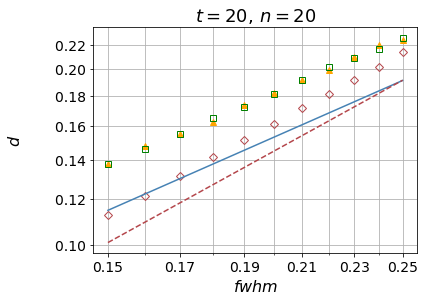

poi
Fit: $d = 0.362\fwhm^{1.01}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9446737408572623

VSG
Fit: $d = 0.343\fwhm^{0.976}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9963239008920743

gauss
coeff:  2.2888471758213167
Fit: $d = 0.479\fwhm^{1.23}$\\
Theory: $d = 0.484\fwhm^{1.25}$
Ratio:  1.0100287763170797

d_vs_fwhm_t=500_n=500_dims=1_q=500_withoutBinomial


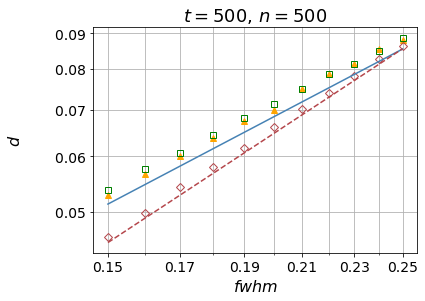

In [3]:
fileEnding = 't=20_n=20_seed=6767_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.1, 0.30, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 'fwhm', xLabels, minorTicksX, yLabels,
                     logged = True, loggedFormula = False, dims = 1, legend = False, includeBinomial = False)

#####################################

fileEnding = 't=500_n=500_seed=6767_q=500.csv' 

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )
yLabels = np.around( np.arange(0.04, 0.1, 0.01), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 'fwhm', xLabels, minorTicksX, yLabels,
                      logged = True, loggedFormula = False, dims = 1, legend = False, includeBinomial = False)

## d vs t

poi
Fit:    $ d = 0.509\,t^{-0.344}$\\
Theory: $ d = 0.323\, t^{-0.250}$

VSG
Fit:    $ d = 0.475\,t^{-0.323}$\\
Theory: $ d = 0.323\, t^{-0.250}$

gauss
coeff:  2.2888471758213167
Fit:    $ d = 1.19\,t^{-0.671}$\\
Theory: $ d = 0.647\, t^{-0.5}$

d_vs_t_fwhm=20_n=20_dims=1_q=500_withoutBinomial


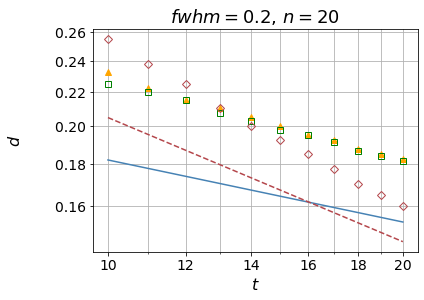

poi
Fit:    $ d = 0.402\,t^{-0.28}$\\
Theory: $ d = 0.323\, t^{-0.250}$

VSG
Fit:    $ d = 0.402\,t^{-0.28}$\\
Theory: $ d = 0.323\, t^{-0.250}$

gauss
coeff:  2.2888471758213167
Fit:    $ d = 2.23\,t^{-0.57}$\\
Theory: $ d = 1.45\, t^{-0.5}$

d_vs_t_fwhm=20_n=500_dims=1_q=500_withoutBinomial


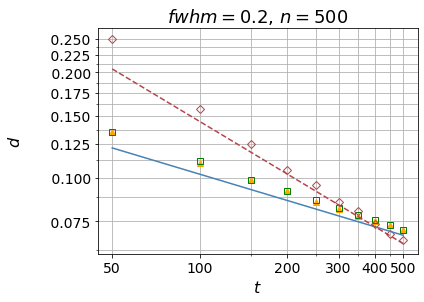

In [4]:
fileEnding = 'fwhm=20_n=20_seed=6767_q=500.csv'  


xLabels = np.arange(10, 21, 2)
minorTicksX = np.arange(10, 21, 1)

yLabels = np.around( np.arange(0.14, 0.27, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 't', xLabels, minorTicksX, yLabels,
                     loggedFormula = False, legend = False, includeBinomial = False)

############################################

fileEnding = 'fwhm=20_n=500_seed=6767_q=500.csv'  

howMany = 6
xLabels = np.arange(100, 510, 100)
xLabels = np.insert(xLabels, 0, 50)
minorTicksX = np.arange(50, 500, 50)

yLabels = np.around( np.arange(0.05, 0.261, 0.025), decimals=3 )
minorTicksY = np.around( np.arange(0.05, 0.26, 0.0125), decimals=3 )
# minorTicksY = []

saveAllPlotsTogether(fileEnding, filePath1D, 't', xLabels, minorTicksX, yLabels, minorTicksY, yDecimals = 3,
                     logged = True, loggedFormula = False, dims = 1, legend = False, includeBinomial = False)


## d vs n

poi
Fit: $d = 0.18\,n^{3.8e-16}$\\
Theory: $d = 0.153$

VSG
Fit: $d = 0.174\,n^{0.0061}$\\
Theory: $d = 0.153$

gauss
coeff:  2.2888471758213167
Fit: $d = 0.0509\,n^{0.365}$\\
Theory: $d = 0.0685\,n^{0.25}$

d_vs_n_t=20_fwhm=20_dims=1_q=500_withoutBinomial


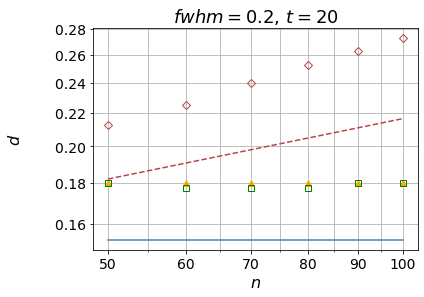

poi
Fit: $d = 0.0731\,n^{-0.0062}$\\
Theory: $d = 0.0684$

VSG
Fit: $d = 0.0721\,n^{-0.00251}$\\
Theory: $d = 0.0684$

gauss
coeff:  2.2888471758213167
Fit: $d = 0.0138\,n^{0.252}$\\
Theory: $d = 0.0137\,n^{0.25}$

d_vs_n_t=500_fwhm=20_dims=1_q=500_withoutBinomial


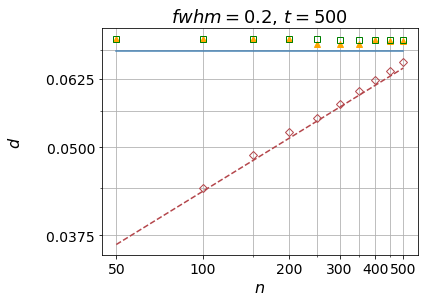

In [5]:
fileEnding = 't=20_fwhm=20_seed=6767_q=500.csv'  

xLabels = np.arange(50, 101, 10)
minorTicksX = np.arange(50, 100, 5)

yLabels = np.around( np.arange(0.14, 0.28, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 'n', xLabels, minorTicksX, yLabels, logged = True, dims = 1,
                     loggedFormula = False, legend = False, includeBinomial = False)

############################################

fileEnding = 't=500_fwhm=20_seed=6767_q=500.csv'

howMany = 6
xLabels = np.arange(100, 510, 100)
xLabels = np.insert(xLabels, 0, 50)
minorTicksX = np.arange(50, 500, 50)

yLabels = np.around( np.arange(0.0375, 0.08751, 0.0125), decimals=4 )
minorTicksY = np.around( np.arange(0.0375, 0.0751, 0.00625), decimals=4 )
# minorTicksY = []

saveAllPlotsTogether(fileEnding, filePath1D, 'n', xLabels, minorTicksX, yLabels, minorTicksY, logged = True,
                     loggedFormula = False, yDecimals = 4, dims = 1, legend = False, includeBinomial = False)


# asymmetric q = 0.2 case

## d vs fwhm

bin
Fit: $d = 1.05\fwhm^{0.918}$\\
Theory: $d = 0.956\fwhm$
Ratio:  0.9078232511242985

poi
Fit: $d = 1.1\fwhm^{0.971}$\\
Theory: $d = 0.956\fwhm$
Ratio:  0.8725153426158885

VSG
Fit: $d = 1.05\fwhm^{0.944}$\\
Theory: $d = 0.956\fwhm$
Ratio:  0.9128315605919209

gauss
coeff:  2.8610589697766455
Fit: $d = 1.8\fwhm^{1.31}$\\
Theory: $d = 1.35\fwhm^{1.25}$
Ratio:  0.7519342832519665

d_vs_fwhm_t=20_n=20_dims=1_q=200


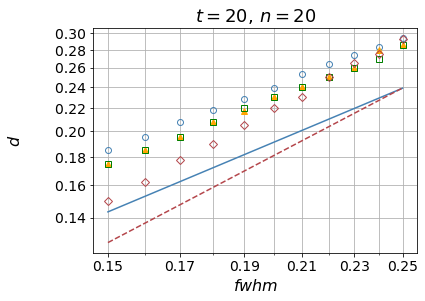

bin
Fit: $d = 0.429\fwhm^{0.979}$\\
Theory: $d = 0.427\fwhm$
Ratio:  0.9960101024484824

poi
Fit: $d = 0.442\fwhm^{1.01}$\\
Theory: $d = 0.427\fwhm$
Ratio:  0.9676766709428155

VSG
Fit: $d = 0.435\fwhm^{0.995}$\\
Theory: $d = 0.427\fwhm$
Ratio:  0.9831643424249807

gauss
coeff:  2.8610589697766455
Fit: $d = 0.63\fwhm^{1.26}$\\
Theory: $d = 0.605\fwhm^{1.25}$
Ratio:  0.9603671093871411

d_vs_fwhm_t=500_n=500_dims=1_q=200


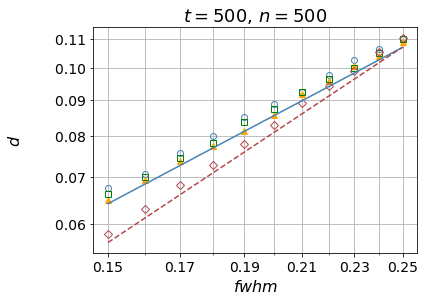

In [6]:
fileEnding = 't=20_n=20_seed=6767_q=200.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.1, 0.32, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 'fwhm', xLabels, minorTicksX, yLabels, q = 0.2,
                     logged = True, loggedFormula = False, dims = 1, legend = False)


#####################################

fileEnding = 't=500_n=500_seed=6767_q=200.csv' 

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )
yLabels = np.around( np.arange(0.04, 0.13, 0.01), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 'fwhm', xLabels, minorTicksX, yLabels, q = 0.2,
                      logged = True, loggedFormula = False, dims = 1, legend = False)

## d vs t

bin
Fit:    $ d = 0.788\,t^{-0.4}$\\
Theory: $ d = 0.404\, t^{-0.250}$

poi
Fit:    $ d = 0.804\,t^{-0.416}$\\
Theory: $ d = 0.404\, t^{-0.250}$

VSG
Fit:    $ d = 0.717\,t^{-0.385}$\\
Theory: $ d = 0.404\, t^{-0.250}$

gauss
coeff:  2.8610589697766455
Fit:    $ d = 3.27\,t^{-0.912}$\\
Theory: $ d = 0.809\, t^{-0.5}$

d_vs_t_fwhm=20_n=20_dims=1_q=200


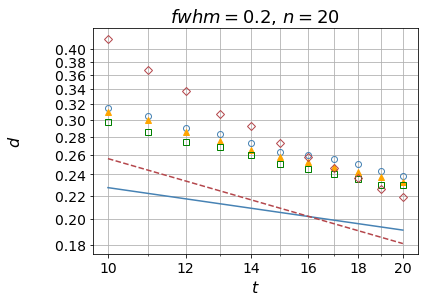

bin
Fit:    $ d = 0.494\,t^{-0.278}$\\
Theory: $ d = 0.404\, t^{-0.250}$

poi
Fit:    $ d = 0.5\,t^{-0.282}$\\
Theory: $ d = 0.404\, t^{-0.250}$

VSG
Fit:    $ d = 0.503\,t^{-0.282}$\\
Theory: $ d = 0.404\, t^{-0.250}$

gauss
coeff:  2.8610589697766455
Fit:    $ d = 5.16\,t^{-0.673}$\\
Theory: $ d = 1.81\, t^{-0.5}$

d_vs_t_fwhm=20_n=500_dims=1_q=200


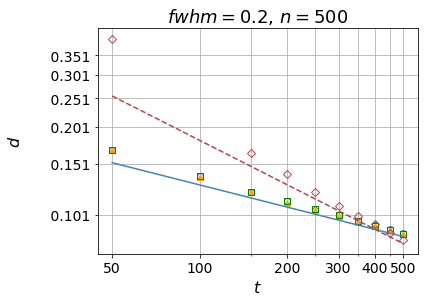

In [45]:
fileEnding = 'fwhm=20_n=20_seed=6767_q=200.csv'  


xLabels = np.arange(10, 21, 2)
minorTicksX = np.arange(10, 21, 1)

yLabels = np.around( np.arange(0.18, 0.40, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 't', xLabels, minorTicksX, yLabels, q = 0.2,
                     loggedFormula = False, legend = False)

############################################

fileEnding = 'fwhm=20_n=500_seed=6767_q=200.csv'  

howMany = 6
xLabels = np.arange(100, 510, 100)
xLabels = np.insert(xLabels, 0, 50)
minorTicksX = np.arange(50, 500, 50)

yLabels = np.around( np.arange(0.001, 0.4, 0.05), decimals=3 )
minorTicksY = np.around( np.arange(0.001, 0.25, 0.05), decimals=3 )
# minorTicksY = []

saveAllPlotsTogether(fileEnding, filePath1D, 't', xLabels, minorTicksX, yLabels, minorTicksY, yDecimals = 3,\
                     q = 0.2, logged = True, loggedFormula = False, dims = 1, legend = False)


## d vs n

bin
Fit: $d = 0.252\,n^{-0.0168}$\\
Theory: $d = 0.191$

poi
Fit: $d = 0.241\,n^{-0.0115}$\\
Theory: $d = 0.191$

VSG
Fit: $d = 0.261\,n^{-0.0327}$\\
Theory: $d = 0.191$

gauss
coeff:  2.8610589697766455
Fit: $d = 0.0294\,n^{0.6}$\\
Theory: $d = 0.0856\,n^{0.25}$

d_vs_n_t=20_fwhm=20_dims=1_q=200


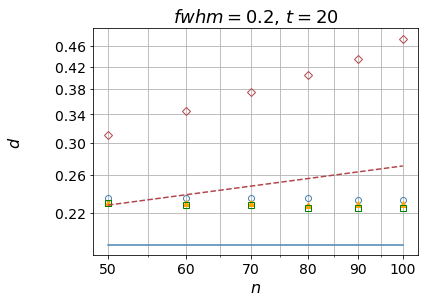

bin
Fit: $d = 0.106\,n^{-0.0295}$\\
Theory: $d = 0.0855$

poi
Fit: $d = 0.0882\,n^{-0.00169}$\\
Theory: $d = 0.0855$

VSG
Fit: $d = 0.0875\,n^{-5.65e-16}$\\
Theory: $d = 0.0855$

gauss
coeff:  2.8610589697766455
Fit: $d = 0.017\,n^{0.255}$\\
Theory: $d = 0.0171\,n^{0.25}$

d_vs_n_t=500_fwhm=20_dims=1_q=200


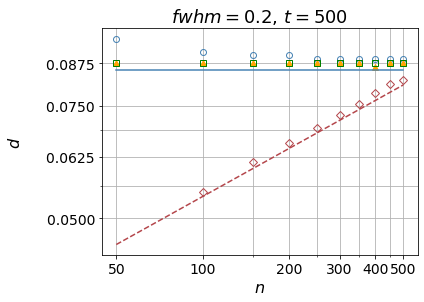

In [8]:
fileEnding = 't=20_fwhm=20_seed=6767_q=200.csv'  

xLabels = np.arange(50, 101, 10)
minorTicksX = np.arange(50, 100, 5)

yLabels = np.around( np.arange(0.14, 0.5, 0.04), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath1D, 'n', xLabels, minorTicksX, yLabels, logged = True, dims = 1, q = 0.2,
                     loggedFormula = False, legend = False)

############################################

fileEnding = 't=500_fwhm=20_seed=6767_q=200.csv'

howMany = 6
xLabels = np.arange(100, 510, 100)
xLabels = np.insert(xLabels, 0, 50)
minorTicksX = np.arange(50, 500, 50)

yLabels = np.around( np.arange(0.0375, 0.08751, 0.0125), decimals=4 )
minorTicksY = np.around( np.arange(0.0375, 0.0751, 0.00625), decimals=4 )
# minorTicksY = []

saveAllPlotsTogether(fileEnding, filePath1D, 'n', xLabels, minorTicksX, yLabels, minorTicksY, q = 0.2,
                     logged = True, loggedFormula = False, yDecimals = 4, dims = 1, legend = False)


# 2 dimensions

## d vs fwhm1

poi
Fit: $d = 0.898\fwhm^{0.987}$\\
Theory: $d = 0.765\fwhm$
Ratio:  0.8516573896016283

VSG
Fit: $d = 0.865\fwhm^{0.971}$\\
Theory: $d = 0.765\fwhm$
Ratio:  0.8834659748639292

gauss
coeff:  1.695454335169755
Fit: $d = 3.02\fwhm^{1.42}$\\
Theory: $d = 1.7\fwhm^{1.25}$
Ratio:  0.5615529409413443

d_vs_fwhm_first_t=20_n=20_dims=2_q=500_withoutBinomial


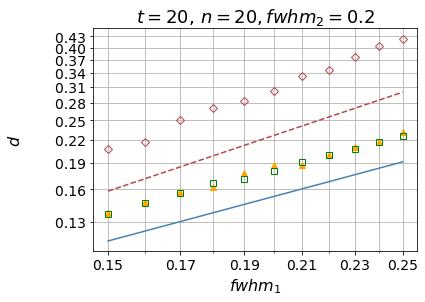

poi
Fit: $d = 0.354\fwhm^{0.995}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9659914735860096

VSG
Fit: $d = 0.35\fwhm^{0.988}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.977636817785693

gauss
coeff:  1.695454335169755
Fit: $d = 2.82\fwhm^{1.39}$\\
Theory: $d = 1.7\fwhm^{1.25}$
Ratio:  0.6018781962247056

d_vs_fwhm_first_t=500_n=500_dims=2_q=500_withoutBinomial


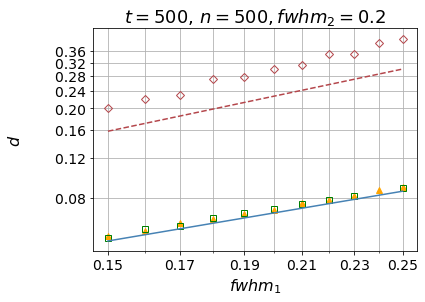

In [31]:
fileEnding = 't=20_n=20_seed=6767_fwhm=first_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.1, 0.44, 0.03), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath2D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'first',
                     logged = True, loggedFormula = False, dims = 2, legend = False, includeBinomial = False)

#####################################

fileEnding = 't=500_n=500_seed=6767_fwhm=first_q=500.csv' 

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )
yLabels = np.around( np.arange(0.04, 0.4, 0.04), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath2D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'first',
                      logged = True, loggedFormula = False, dims = 2, legend = False, includeBinomial = False)

######################################

## d vs fwhm2

poi
Fit: $d = 0.173\fwhm^{-0.0259}$\\
Theory: $d = 0.153$\\
Ratio:  0.8848241420312988

VSG
Fit: $d = 0.18\fwhm^{-0.00835}$\\
Theory: $d = 0.153$\\
Ratio:  0.8516006004970927

gauss
coeff:  0.339090867033951
Fit: $d = 0.662\fwhm^{0.474}$\\
Theory: $d = 0.339\fwhm^{0.25}$
Ratio:  0.5123609821685765

d_vs_fwhm_second_t=20_n=20_dims=2_q=500_withoutBinomial


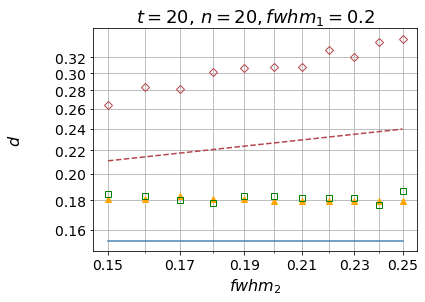

poi
Fit: $d = 0.0683\fwhm^{-0.018}$\\
Theory: $d = 0.0684$\\
Ratio:  1.0011209547565147

VSG
Fit: $d = 0.069\fwhm^{-0.0166}$\\
Theory: $d = 0.0684$\\
Ratio:  0.991824068549737

gauss
coeff:  0.339090867033951
Fit: $d = 0.585\fwhm^{0.413}$\\
Theory: $d = 0.339\fwhm^{0.25}$
Ratio:  0.5794029385824925

d_vs_fwhm_second_t=500_n=500_dims=2_q=500_withoutBinomial


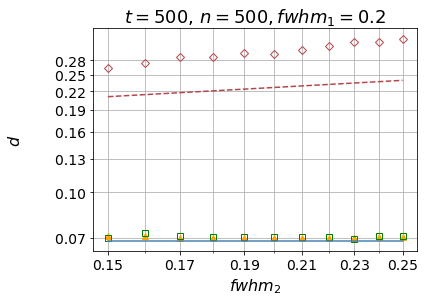

In [33]:
fileEnding = 't=20_n=20_seed=6767_fwhm=second_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.1, 0.34, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath2D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'second',
                     logged = True, loggedFormula = False, dims = 2, legend = False, includeBinomial = False)

#####################################

fileEnding = 't=500_n=500_seed=6767_fwhm=second_q=500.csv' 

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )
yLabels = np.around( np.arange(0.04, 0.3, 0.03), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath2D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'second',
                      logged = True, loggedFormula = False, dims = 2, legend = False, includeBinomial = False)

## d vs fwhm1 = fwhm2

poi
Fit: $d = 0.844\fwhm^{0.95}$\\
Theory: $d = 0.765\fwhm$
Ratio:  0.9060014869210627

VSG
Fit: $d = 0.89\fwhm^{0.985}$\\
Theory: $d = 0.765\fwhm$
Ratio:  0.8595112123485017

gauss
coeff:  2.535295573712328
Fit: $d = 6.11\fwhm^{1.85}$\\
Theory: $d = 2.54\fwhm^{1.5}$
Ratio:  0.41527579321084696

d_vs_fwhm_both_t=20_n=20_dims=2_q=500_withoutBinomial


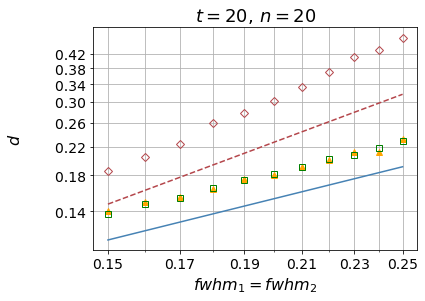

poi
Fit: $d = 0.368\fwhm^{1.02}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9284430354212923

VSG
Fit: $d = 0.355\fwhm^{0.999}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9631167496607779

gauss
coeff:  2.535295573712328
Fit: $d = 6.61\fwhm^{1.91}$\\
Theory: $d = 2.54\fwhm^{1.5}$
Ratio:  0.3835424954653095

d_vs_fwhm_both_t=500_n=500_dims=2_q=500_withoutBinomial


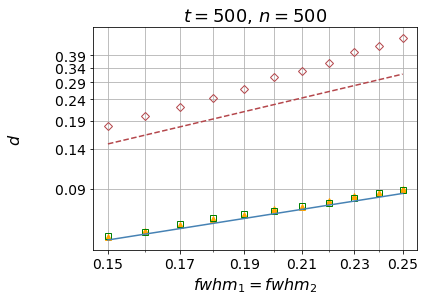

In [50]:
fileEnding = 't=20_n=20_seed=6767_fwhm=both_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.1, 0.44, 0.04), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath2D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'both',
                     logged = True, loggedFormula = False, dims = 2, legend = False, includeBinomial = False)

#####################################

fileEnding = 't=500_n=500_seed=6767_fwhm=both_q=500.csv' 

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )
yLabels = np.around( np.arange(0.04, 0.44, 0.05), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath2D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'both',
                      logged = True, loggedFormula = False, dims = 2, legend = False, includeBinomial = False)

## Check 3D Gaussian model

fwhm =  0.15 ,..., 0.15
n =  50
t =  500

q =  0.5
coeff:  1.2559009762696032
Fit: $d = 1.28\fwhm^{1.31}$\\
Theory: $d = 1.06\fwhm^{1.25}$
Ratio:  0.8277456782768713


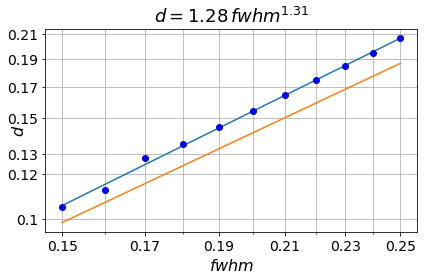



---------------------------------------------------------------------


In [4]:
fileName = cwd + '/simulationData3D/gauss_fwhm_t=500_n=50_seed=6767_fwhm=first_q=500.csv'
fitLine(fileName, 'fwhm', dims = 3)

# 3 dimensions

## d vs fwhm1

bin
Fit: $d = 0.369\fwhm^{1.01}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9274912009245441

poi
Fit: $d = 0.364\fwhm^{1.01}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9385454602715461

VSG
Fit: $d = 0.325\fwhm^{0.945}$\\
Theory: $d = 0.342\fwhm$
Ratio:  1.0512095002019173

gauss
coeff:  1.2559009762696032
Fit: $d = 1.28\fwhm^{1.31}$\\
Theory: $d = 1.06\fwhm^{1.25}$
Ratio:  0.8277456782768713

d_vs_fwhm_first_t=500_n=50_dims=3_q=500


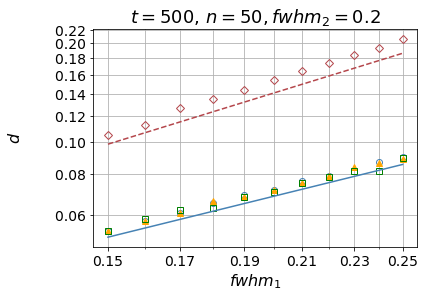

In [34]:
fileEnding = 't=500_n=50_seed=6767_fwhm=first_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.02, 0.30, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath3D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'first',
                     logged = True, loggedFormula = False, dims = 3, legend = False, includeBinomial = True)

## d vs fwhm2

bin
Fit: $d = 0.072\fwhm^{0.00518}$\\
Theory: $d = 0.0684$\\
Ratio:  0.9497919022311806

poi
Fit: $d = 0.0744\fwhm^{0.0264}$\\
Theory: $d = 0.0684$\\
Ratio:  0.918794935563879

VSG
Fit: $d = 0.07\fwhm^{-0.0108}$\\
Theory: $d = 0.0684$\\
Ratio:  0.9768159129616953

gauss
coeff:  0.25118019525392066
Fit: $d = 0.241\fwhm^{0.276}$\\
Theory: $d = 0.211\fwhm^{0.25}$
Ratio:  0.8768630104797732

d_vs_fwhm_second_t=500_n=50_dims=3_q=500


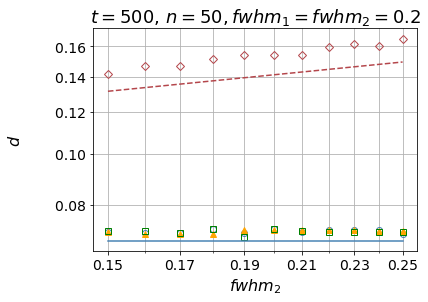

In [35]:
fileEnding = 't=500_n=50_seed=6767_fwhm=second_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.02, 0.30, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath3D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'second',
                     logged = True, loggedFormula = False, dims = 3, legend = False, includeBinomial = True)

## d vs fwhm3

bin
Fit: $d = 0.0674\fwhm^{-0.0391}$\\
Theory: $d = 0.0684$\\
Ratio:  1.0154430090285336

poi
Fit: $d = 0.0709\fwhm^{-0.00453}$\\
Theory: $d = 0.0684$\\
Ratio:  0.9644126307355191

VSG
Fit: $d = 0.0685\fwhm^{-0.0255}$\\
Theory: $d = 0.0684$\\
Ratio:  0.9987890806775052

gauss
coeff:  0.25118019525392066
Fit: $d = 0.243\fwhm^{0.283}$\\
Theory: $d = 0.211\fwhm^{0.25}$
Ratio:  0.869960086276205

d_vs_fwhm_third_t=500_n=50_dims=3_q=500


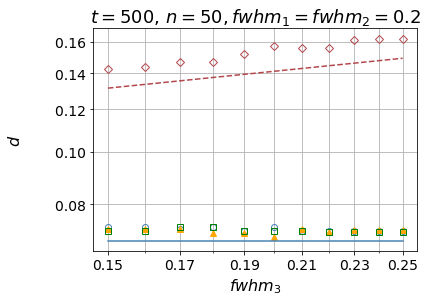

In [36]:
fileEnding = 't=500_n=50_seed=6767_fwhm=third_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.02, 0.30, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath3D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'third',
                     logged = True, loggedFormula = False, dims = 3, legend = False, includeBinomial = True)

## d vs fwhm1 = fwhm2 = fwhm3

bin
Fit: $d = 0.328\fwhm^{0.945}$\\
Theory: $d = 0.342\fwhm$
Ratio:  1.0417558870841388

poi
Fit: $d = 0.366\fwhm^{1.01}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9333583079550787

VSG
Fit: $d = 0.349\fwhm^{0.988}$\\
Theory: $d = 0.342\fwhm$
Ratio:  0.9809381831061308

gauss
coeff:  2.808279955947183
Fit: $d = 3.33\fwhm^{1.91}$\\
Theory: $d = 2.36\fwhm^{1.75}$
Ratio:  0.7085079841539522

d_vs_fwhm_all_t=500_n=50_dims=3_q=500


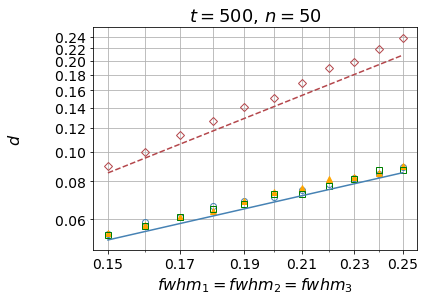

In [37]:
fileEnding = 't=500_n=50_seed=6767_fwhm=all_q=500.csv'

howMany = 6
xLabels = np.around( np.linspace(0.15, 0.25, num=howMany), decimals=2 )
minorTicksX = np.around( np.linspace(0.15, 0.25, num=2*howMany-1), decimals=2 )

yLabels = np.around( np.arange(0.02, 0.30, 0.02), decimals=2 )

saveAllPlotsTogether(fileEnding, filePath3D, 'fwhm', xLabels, minorTicksX, yLabels, whichFwhm = 'all',
                     logged = True, loggedFormula = False, dims = 3, legend = False, includeBinomial = True)